# **Age, Gender, & Race Detection (CNN): Revisited**

Table of Contents:
* [About the Data/Project](#1)
* [Set Up](#2)
* [Exploratory Data Analysis](#3)
    * [Data Overview](#3.1)
    * [Age](#3.2)
    * [Gender](#3.3)
    * [Race](#3.4)
* [Data Preprocessing](#4)
* [CNN](#5)
    * [Building the Model](#5.1)
    * [Fitting the Model](#5.2)
    * [Model Evaluation](#5.3)
* [Conclusion](#c)
* [References](#r)

<a id="top"></a>

<a href="#2" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="top"></a>

<a id="1"></a>
# **About the Data/Project**

---

This is an updated version of my original attempt at this project. Over the past few years, my grasp of both data science and machine learning techniques has significantly improved. Because of this, I thought it would be a great learning experience to come back to this project and improve upon it. This version will contain:
- More streamlined, explainable code
- A better executed EDA
- A more accurate CNN model (including age, gender, AND race!)

The objective of this project is to develop a convolutional neural network (CNN) that will work to predict the age, gender, and race of the faces found in UTKFace dataset. The accuracy and loss of the CNN model will be analyzed. Lastly, the trained CNN model will work to predict the age and gender on several example images. 

UTKFace, is available both on [Kaggle](https://www.kaggle.com/datasets/jangedoo/utkface-new?datasetId=44109) and on [Github](https://susanqq.github.io/UTKFace/). This dataset is a large-scale face dataset with faces ranging from 0 to 116 years old. This dataset contains over 20,000 face images. Each image includes only a single face, and includes annotations of age, gender, and ethnicity. Age is an integer from 0 to 116, gender is either 0 (male) or 1 (female), and race is an integer from 0 to 4, i.e., White (0), Black (1), Asian (2), Indian (3), Others (4).  These images also contain variation in pose, facial expression, illumination, occlusion, and resolution. This dataset is available for non-commercial research purposes only.

This project was inspired by other great works on this dataset, such as the ones by [Uzair Siddiqui](https://www.kaggle.com/code/uzzivirus/age-and-gender-detection/notebook#From-Unstructured-data-to-Structured-data), [Rahul D Shetty](https://www.kaggle.com/code/rahuldshetty/age-and-gender-estimation-using-cnn), and [Venu Gopal Kadamba](https://www.kaggle.com/code/venugopalkadamba/face-regeneration-using-autoencoders). Their works on this dataset have also been included in the references section below.

<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a href="#3" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="top"></a>

<a id="2"></a>
# **Set Up**

---

In [1]:
# --- Loading necessary libraries and packages ---

# Fundamental Libraries
import numpy as np
import pandas as pd

# Random
import random

# Regex
import re

# Hiding warnings
import warnings
warnings.filterwarnings("ignore")

# Data viz
import matplotlib.pyplot as plt
import seaborn as sns

# Os/Path - Handling files
import os
from pathlib import Path

# Scipy stats
from scipy.stats import skew

# Image
from PIL import Image

# Tensorflow/Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras import layers, models, optimizers


# Sklearn
from sklearn.model_selection import train_test_split

2025-09-26 15:31:01.274363: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758900661.481910      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758900661.545745      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# --- Settings ---
IMG_SIZE = 128
BATCH_SIZE = 32
RANDOM_STATE = 42

In [3]:
# --- Veryifing GPU ---
# If 1, good to go!
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [4]:
# --- Verifying input file names ---
!ls /kaggle/input

crop_part1  UTKFace  utkface_aligned_cropped


In [5]:
# --- Build dataframe function ---
    
# Setting PATH
PATH = Path("/kaggle/input/UTKFace")

# Defining build_dataframe function
def build_dataframe(data_dir: Path):
    rows = []
    for p in data_dir.glob("*.jpg"):
        name = p.name
        # UTKFace filenames are like: age_gender_race_date.jpg
        parts = name.split('_')
        if len(parts) < 3:
            # unexpected filename
            continue
        try:
            age = float(parts[0])
            gender = int(parts[1])  # 0 male, 1 female
            race = int(parts[2])    # 0-4 
        except Exception:
            # skip corrupted / unexpected
            continue
        rows.append({
            "image": name,
            "path": str(p),     # absolute path as string
            "age": age,
            "gender": gender,
            "race": race
        })
    df = pd.DataFrame(rows)
    return df

# Applying function
df = build_dataframe(PATH)

In [6]:
# --- Sanity check ---

# Checking total number of images (should be 23705)
print("Total images:", len(df))
# Checking summary stats of age
print(df.age.describe())

print(df.gender.value_counts())
# Checking unique race labels (should be 5)
print("Unique race labels: ", df['race'].unique())

Total images: 23705
count    23705.000000
mean        33.300907
std         19.885708
min          1.000000
25%         23.000000
50%         29.000000
75%         45.000000
max        116.000000
Name: age, dtype: float64
gender
0    12391
1    11314
Name: count, dtype: int64
Unique race labels:  [2 1 3 0 4]


<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a href="#4" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="top"></a>

<a id="3"></a>
# **Exploratory Data Analysis**

---

<a id="top"></a>
<a id="3.1"></a>
## **Data Overview**

In [7]:
# --- Quick view of the dataframe ---
df.head()

,image,path,age,gender,race
0,26_0_2_20170104023102422.jpg.chip.jpg,/kaggle/input/UTKFace/26_0_2_20170104023102422...,26.0,0,2
1,22_1_1_20170112233644761.jpg.chip.jpg,/kaggle/input/UTKFace/22_1_1_20170112233644761...,22.0,1,1
2,21_1_3_20170105003215901.jpg.chip.jpg,/kaggle/input/UTKFace/21_1_3_20170105003215901...,21.0,1,3
3,28_0_0_20170117180555824.jpg.chip.jpg,/kaggle/input/UTKFace/28_0_0_20170117180555824...,28.0,0,0
4,17_1_4_20170103222931966.jpg.chip.jpg,/kaggle/input/UTKFace/17_1_4_20170103222931966...,17.0,1,4


From the Set Up steps, we can now see that there are 23705 images in the UTKFace dataset. By viewing five examples of these, we can get an idea of the structure of the naming convention. For example, the first filename shown above is '26_0_2_20170104023102422.jpg.chip.jpg'. The first three numbers reflect the age, gender, and race of the face in the image, respectively. So, this particular face would have an age of 26, gender as male (0), and race as Asian (2). 

In [8]:
# --- Viewing data info ---
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   23705 non-null  object 
 1   path    23705 non-null  object 
 2   age     23705 non-null  float64
 3   gender  23705 non-null  int64  
 4   race    23705 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 926.1+ KB


Above, we can confirm the overall structure of the dataframe. Again, there are 23705 images and 4 columns. 

Age is represented as a float value, e.g. 26.0.

Gender is represented as an integer value, and is either 0 or 1.

Race is also represented as an integer value, and has values 0 to 4. 

In [9]:
# --- Checking skewness ---
df.skew(numeric_only=True)

age       0.622041
gender    0.090967
race      0.618338
dtype: float64

Above, we check the skewness of age, gender, and race. Skewness is a measure of the symmetry of the distribution of data, i.e. how the data is spread out. This measure can help us identify outliers. A skewness of 0 indicates that the distribution is perfectly symmetrical (think normal distribution). A negative skewness indicates that most of the data values are on the right side (along the x-axis of a graph), with a tail (fewer values) on the left side. A positive skewness indicates that most of the data values are on the left side, with a tail on the right side.

Gender has no significant skew. This suggests that the distribution of male and female faces is roughly equal.

Age and race have moderate positive skewness (0.622 and 0.618). For age, this suggests that most of the images are of younger faces (lower age values). For race, it is important to consider that while this column is numeric, the values 0 to 4 represent categories. The race column has moderate skewness due to the fact that the majority of faces are in the 0 category (white).

<a id="top"></a>
<a id="3.2"></a>
## **Age**

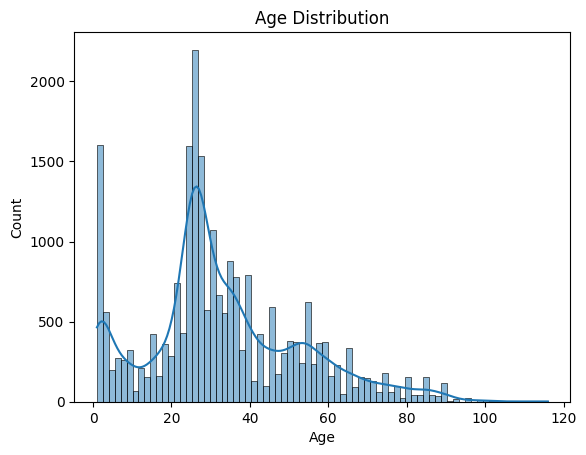

In [10]:
# --- Plotting the distribution of age ---
ax = sns.histplot(x='age', data=df, palette='Set2', kde=True)
ax.set_ylabel('Count')
ax.set_xlabel('Age')
ax.set_title('Age Distribution')
plt.show()

Above, we can see the distribution of age. At a glance, the highest distribution of age appears to be between 20 and 40 years (~25 years). There also appears to be a higher distribution of faces with ages around 0. This distribution is confirmed by the moderate skewness of 0.622. In other words, the majority of faces have younger ages (lower x-values) and have a right tailed distribution. Because of this, there are much fewer older faces (higher x-values).

<a id="top"></a>
<a id="3.3"></a>
## **Gender**

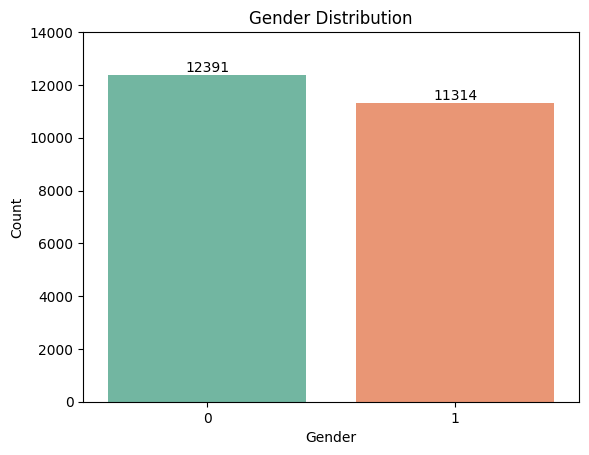

In [11]:
# --- Creating countplot for gender ---
ax = sns.countplot(x='gender', data=df, palette='Set2')
for label in ax.containers:
  ax.bar_label(label)
ax.set_ylabel('Count')
ax.set_xlabel('Gender')
ax.set_title('Gender Distribution')
ax.set_ylim(0, 14000)
plt.show()

In [12]:
# --- Checking the % proportion of each gender class ---
print(df['gender'].value_counts(normalize=True))

gender
0    0.522717
1    0.477283
Name: proportion, dtype: float64


Above, we can see the distribution of gender. At a glance, it is clear that there are slightly more faces with gender=0 (male, 12391) than there are faces with gender=1 (female, 11314). However, this difference does not appear to be significant, as ~52.3% are male faces and ~47.7% are female faces. 

This is good news, as there is no class imbalance here.

<a id="top"></a>
<a id="3.4"></a>
## **Race**

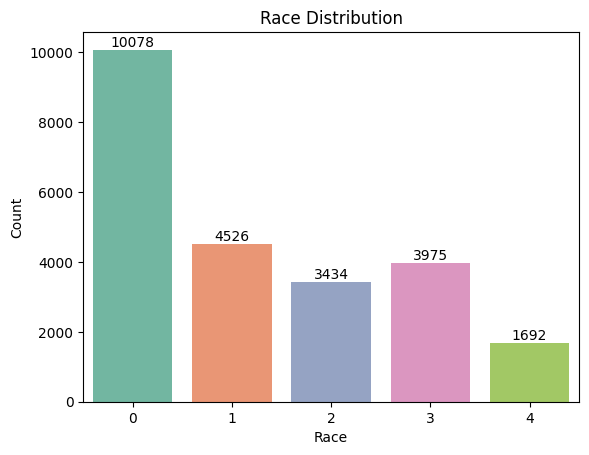

In [13]:
# --- Creating countplot for race ---
ax = sns.countplot(x='race', data=df, palette='Set2')
for label in ax.containers:
  ax.bar_label(label)
ax.set_ylabel('Count')
ax.set_xlabel('Race')
ax.set_title('Race Distribution')
plt.show()

In [14]:
# --- Checking the % proportion of each race class ---
print(df['race'].value_counts(normalize=True))

race
0    0.425142
1    0.190930
3    0.167686
2    0.144864
4    0.071377
Name: proportion, dtype: float64


Above, we can see the distribution of race. The five classes have the following distributions:

- 0 (White): 10078, ~42.5%
- 1 (Black): 4526, ~19.1%
- 2 (Asian): 3434, ~16.8%
- 3 (Indian): 3975, ~14.5%
- 4 (Others): 1692, ~7.1%

As mentioned earlier, race also has a moderate positive skew of 0.618. This is due to the fact that the majority of faces are class 0 (white).

<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a href="#5" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="top"></a>

<a id="4"></a>
# **Data Preprocessing**

---

In [15]:
def age_group(age):
    if 0 <= age < 18:
        return 0   # Keras likes 0-based labels
    elif age < 30:
        return 1
    elif age < 80:
        return 2
    else:
        return 3

df['age_group'] = df['age'].apply(age_group)
n_age_bins = df['age_group'].nunique()
print("Number of age bins:", n_age_bins)
print(df['age_group'].value_counts())

Number of age bins: 4
age_group
2    11095
1     7704
0     4233
3      673
Name: count, dtype: int64


In [16]:
# --- Train/test split (stratify by gender+race) ---
train, test = train_test_split(
df, test_size=0.2, random_state=RANDOM_STATE,
stratify=df['gender'].astype(str) + "_" + df['race'].astype(str)
) 

# --- Preprocessing ---
def preprocess_image(path, img_size=IMG_SIZE, training=False):
    # Reading in the image
    def _load_img(p):
        p = p.numpy().decode("utf-8")  # convert tensor to Python string path
        img = load_img(p, target_size=(img_size, img_size)) # load image resized
        img = img_to_array(img)/255.0 # convert to array and scale pixel values
        return img.astype(np.float32)
    # Wrapper that loads an image from disk into a TensorFlow tensor
    img = tf.py_function(func=_load_img, inp=[path], Tout=tf.float32)
    img.set_shape([img_size, img_size, 3])  # fix shape for tf.data
    # Applying random augmentations only when training
    if training:
        img = tf.image.random_flip_left_right(img) # random horizontal flip
        img = tf.image.random_brightness(img, 0.1) # random brightness adjustment
        img = tf.image.random_contrast(img, 0.8, 1.2) # random contrast adjustment
    return img

# --- Making dataset from preprocessed data ---
def make_dataset(df_in, batch_size=BATCH_SIZE, training=False):
    paths = df_in['path'].values
    genders = df_in['gender'].values.astype(np.float32)
    ages = df_in['age_group'].values.astype(np.int32)
    races = df_in['race'].values.astype(np.int32)

    # Creating TensorFlow dataset 
    ds = tf.data.Dataset.from_tensor_slices((paths, genders, ages, races))

    # Mapping function: loading + preprocessing image, returning image with labels
    def _map(path, gender, age, race):
        img = preprocess_image(path, img_size=IMG_SIZE, training=training)
        return img, (gender, age, race)
    # Shuffling the dataset when training
    if training:
        ds = ds.shuffle(len(df_in), seed=RANDOM_STATE)
    # Applying mapping in parallel for efficiency
    ds = ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE)
    # Batching and prefetching for optimized GPU training
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# --- Applying make_dataset function ---
train_ds = make_dataset(train, training=True)
test_ds = make_dataset(test, training=False)

I0000 00:00:1758900677.634926      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a href="#6" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="top"></a>

<a id="5"></a>
# **CNN**

---

<a id="top"></a>
<a id="5.1"></a>
## **Building the Model**

In [17]:
# --- Building the CNN ---
    
# --- Input ---
inputs = Input((IMG_SIZE, IMG_SIZE, 3))

# --- Convolutional blocks ---
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer = glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

# --- Dense layers for multi-task outputs ---
dense_1 = layers.Dense(256, activation='relu')(X)
dense_2 = layers.Dense(128, activation='relu')(dense_1)
dropout = layers.Dropout(0.3)(dense_2)

# --- Output heads ---
# Gender (binary)
output_gender = Dense(1,activation='sigmoid', name='gender_output')(dropout)
# Age (categorical)
output_age = Dense(4, activation='softmax', name='age_output')(dropout)
# Race (categorical)
output_race = Dense(5, activation='softmax', name='race_output')(dropout)

# --- Building the model ---
model = Model(inputs=[inputs], outputs=[output_gender,output_age, output_race])

# --- Compile ---
model.compile(
    optimizer='adam',
    loss={
        'gender_output': 'binary_crossentropy',
        'age_output': 'sparse_categorical_crossentropy',
        'race_output': 'sparse_categorical_crossentropy'
    },
    loss_weights={
        'gender_output': 1.0,
        'age_output': 1.0,  # emphasize age
        'race_output': 1.0
    },
    metrics={
        'gender_output': ['accuracy'],
        'age_output': ['accuracy'],
        'race_output': ['accuracy']
    }
    )

# --- Viewing model summary ---
# You can comment this out to reduce notebook kernel size
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 126, 126,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 42, 42,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 40, 40,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 20, 20,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 18, 18,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 9, 9, 256) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 20736)     │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  5,308,672 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 1)         │        129 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_output (Dense)  │ (None, 4)         │        516 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ race_output (Dense) │ (None, 5)         │        645 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,713,930 (21.80 MB)

 Trainable params: 5,713,802 (21.80 MB)

 Non-trainable params: 128 (512.00 B)

<a id="top"></a>
<a id="5.2"></a>
## **Fitting the Model**

In [18]:
# --- Fitting the Model ---
# You can set verbose = 1 to print out progress
history = model.fit(train_ds, validation_data=test_ds, epochs=15, verbose=1)

Epoch 1/15


I0000 00:00:1758900686.041574      63 service.cc:148] XLA service 0x7a4bcc006c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758900686.043274      63 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758900686.735543      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/593 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - age_output_accuracy: 0.3805 - age_output_loss: 1.9949 - gender_output_accuracy: 0.5223 - gender_output_loss: 0.9064 - loss: 5.2022 - race_output_accuracy: 0.2307 - race_output_loss: 2.3009

I0000 00:00:1758900691.024721      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


593/593 ━━━━━━━━━━━━━━━━━━━━ 78s 115ms/step - age_output_accuracy: 0.5527 - age_output_loss: 1.0275 - gender_output_accuracy: 0.7063 - gender_output_loss: 0.5459 - loss: 2.8509 - race_output_accuracy: 0.5124 - race_output_loss: 1.2774 - val_age_output_accuracy: 0.6866 - val_age_output_loss: 0.8125 - val_gender_output_accuracy: 0.8496 - val_gender_output_loss: 0.3780 - val_loss: 2.2294 - val_race_output_accuracy: 0.6532 - val_race_output_loss: 1.0483
Epoch 2/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 45s 76ms/step - age_output_accuracy: 0.6963 - age_output_loss: 0.6908 - gender_output_accuracy: 0.8500 - gender_output_loss: 0.3243 - loss: 1.8473 - race_output_accuracy: 0.7073 - race_output_loss: 0.8322 - val_age_output_accuracy: 0.6608 - val_age_output_loss: 0.7749 - val_gender_output_accuracy: 0.8595 - val_gender_output_loss: 0.3375 - val_loss: 2.0007 - val_race_output_accuracy: 0.6920 - val_race_output_loss: 0.8960
Epoch 3/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 46s 77ms/step - age_output_accuracy: 0.726

<a id="top"></a>
<a id="5.3"></a>
## **Model Evaluation**

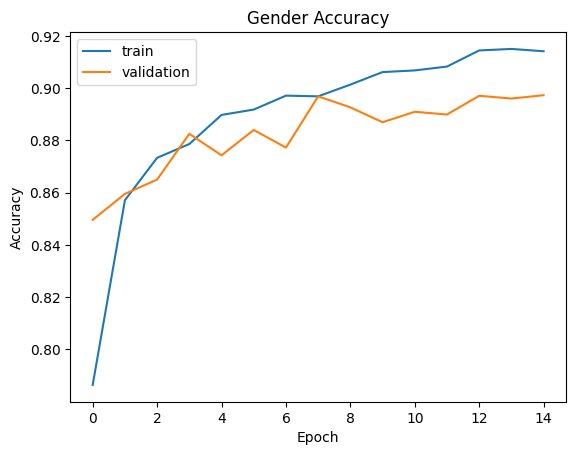

In [19]:
# --- Plotting gender accuracy --- 
plt.plot(history.history['gender_output_accuracy'])
plt.plot(history.history['val_gender_output_accuracy'])
plt.title('Gender Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

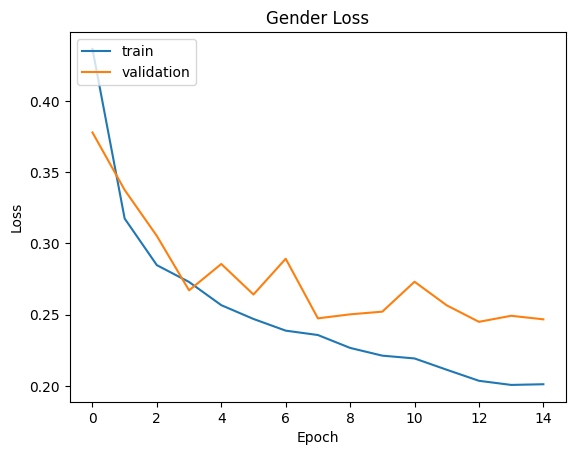

In [20]:
# --- Plotting gender loss ---
plt.plot(history.history['gender_output_loss'])
plt.plot(history.history['val_gender_output_loss'])
plt.title('Gender Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

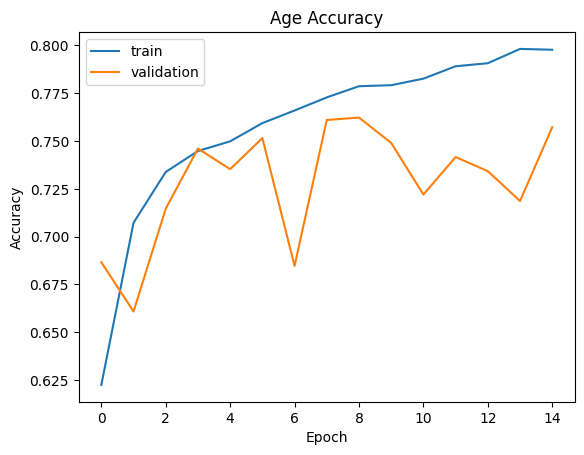

In [21]:
# --- Plotting age accuracy --- 
plt.plot(history.history['age_output_accuracy'])
plt.plot(history.history['val_age_output_accuracy'])
plt.title('Age Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

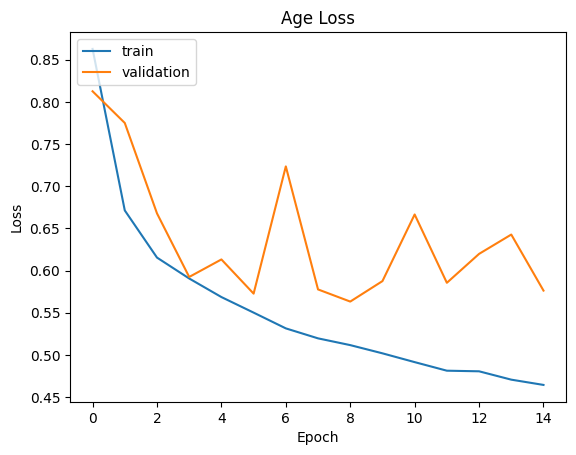

In [22]:
# --- Plotting age loss --- 
plt.plot(history.history['age_output_loss'])
plt.plot(history.history['val_age_output_loss'])
plt.title('Age Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

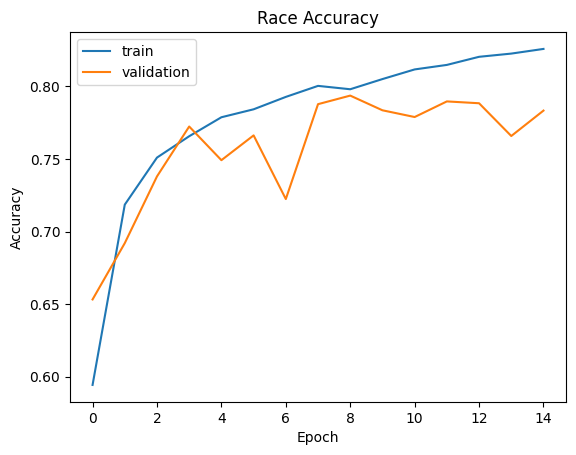

In [23]:
# --- Plotting race accuracy --- 
plt.plot(history.history['race_output_accuracy'])
plt.plot(history.history['val_race_output_accuracy'])
plt.title('Race Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

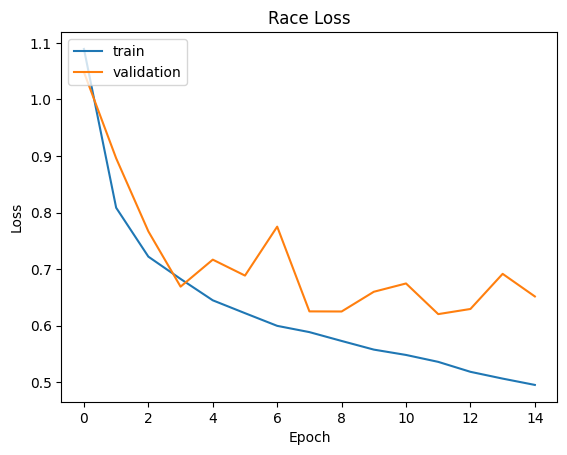

In [24]:
# --- Plotting race loss --- 
plt.plot(history.history['race_output_loss'])
plt.plot(history.history['val_race_output_loss'])
plt.title('Race Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [25]:
# --- Declaring values for gender and race ---
gender_dict = {0:"Male",1:"Female"}
race_dict = {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Other"}
age_dict = {0:"0-17", 1:"18-29", 2:"30-79", 3:"80+"}

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
Original: Gender = Female Age = 30-79 Race = White
Prediction: Gender = Female Age = 30-79 Race = White


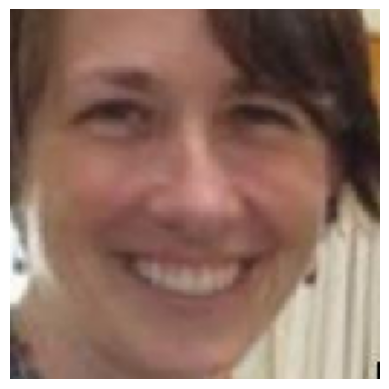

In [26]:
# --- Applying model predictions to a test image ---
# Pick a random batch
batch_index = random.randint(0, len(list(test_ds))-1)
batch = list(test_ds.skip(batch_index).take(1))[0]

# Pick a random image within that batch
img_index = random.randint(0, batch[0].shape[0]-1)
sample_img = batch[0][img_index:img_index+1]

labels = batch[1]
y_gender_sample = labels[0][img_index].numpy()
y_age_sample = labels[1][img_index].numpy()
y_race_sample = labels[2][img_index].numpy()

pred = model.predict(sample_img)
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = age_dict[pred[1][0].argmax()]
pred_race = race_dict[pred[2].argmax()]

print("Original: Gender =", gender_dict[y_gender_sample], "Age =", age_dict[y_age_sample], "Race =", race_dict[y_race_sample])
print("Prediction: Gender =", pred_gender, "Age =", pred_age, "Race =", pred_race)

plt.imshow(sample_img[0])
plt.axis('off')
plt.show()

<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a id="c"></a>
# **Conclusion**

---

**Gender Performance**

Gender accuracy for both train and validation sets increased across epochs. The final gender accuracy scores were:

- 0.9166 (train)
- 0.8910 (validation)

Loss remained low and decreased across epochs for the training and validation. Validation loss was slightly more erratic, and did not decrease as much as training from epoch 6 onwards. The final gender losses were:

- 0.1917 (train)
- 0.2476 (validation)

**Age Performance**

Similar to gender, age accuracy increased across epochs. The training accuracy increased steadily but the validation accuracy was more erratic. The final age accuracy scores were:

- 0.7975 (train)
- 0.7638 (validation)

The losses for age were very similar to that of gender, with a stable decrease in training loss but slight erratic behavior for the validation loss. The final age losses were:

- 0.4543 (train)
- 0.5700 (validation)

**Race Performance**

Race accuracies followed the same pattern, with both training and validation accuracies increasing across epochs. The final race accuracies were:

- 0.8353 (train)
- 0.7870 (validation)

The losses followed the same patterns as above. The final race losses were:

- 0.4852 (train)
- 0.6382 (validation)

**Summary of Findings**

Overall, this iteration of this project has shown much improvement over my original work. Specifically, the model is now far better at predicting age (~80% accuracy vs ~4%!) and can now also predict race (~83%). All predictions (gender, age, race) faired much better than random guess, which shows that this model is progressing in the right direction. 

Despite the improvements, the fluctuations in the validation losses suggest that the model may be slightly overfitting the data.

Future iterations of this project could include the following adjustments:

- Adding more layers to the CNN model
- Adding more regularization
- Using prebuilt models, such as EfficientNetB0
- Different binning techniques for age
- Label smoothing for age

<a id="r"></a>
# **References**

- https://www.kaggle.com/datasets/jangedoo/utkface-new?datasetId=44109
- https://susanqq.github.io/UTKFace/
- https://www.kaggle.com/code/venugopalkadamba/face-regeneration-using-autoencoders
- https://www.kaggle.com/code/uzzivirus/age-and-gender-detection/notebook#Creating-model
- https://www.kaggle.com/code/rahuldshetty/age-and-gender-estimation-using-cnn